# Vasicek Simulation using Numpyro (a probabilistic language similar to PyMC)
by Prabhakar Srivastava

In [1]:
# Libaries
import jax
import jax.numpy as jnp
from jax.random import PRNGKey, split
from jax.scipy.stats import norm
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
import preliz as pz

In [2]:
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

In [3]:
# Random Seed and Plotting Style
random_seed = sum(map(ord, "Numpyro Vasicek"))
rng_key = PRNGKey(random_seed)

az.style.use("arviz-doc")

## A Recap on the Theory <br>
<center> Recall Let $R_i$ be a standard Normal random variable $N(0, 1)$</center>
<center> Default occurs if $R_i < c$</center>
<center> $R_i$ can be decomposed into a systematic risk factor and idiosyncratic as:</center>
<center> $R_i = X \sqrt{\rho} + \epsilon_i \sqrt{1-\rho}$</center>
<center> Both $X$ and $\epsilon_i$ are $N(0,1)$</center>
<center> Where $\rho$ is the correlation </center>
<center> Therefor we have $P(R_i < c) = PD$ or $\Phi(c) = PD$, </center>
<center> $c = \Phi^{-1}(PD)$ for a probability of default, $PD$</center>
<center> $P(R_i < c) = P(X \sqrt{\rho} + \epsilon_i \sqrt{1 - \rho}<c)$</center>
<center> $= P(\epsilon_i < \frac{c - X \sqrt{\rho}}{\sqrt{1 - \rho}})$</center>
<center> $= P(\epsilon_i < \frac{\Phi^{-1}(PD) - X \sqrt{\rho}}{\sqrt{1 - \rho}})$</center>
<center> $= \Phi(\frac{\Phi^{-1}(PD) - X \sqrt{\rho}}{\sqrt{1 - \rho}})$</center>

Simulate Vasicek Defaults

In [4]:
Nborrowers = 100_000_000 # Number of obligors (borrowers)
Nsim = 1_000 # For simulation
ρsim = 0.15
PDsim = 0.25

def simulate_vasicek(rng_key:jnp.array, 
                     ρsim:float=ρsim, 
                     PDsim:float=PDsim, 
                     Nsim:int=Nsim, 
                     Nborrowers:int=Nborrowers) -> jnp.array:
    '''
    Simulate Vasicek Portfolio defaults

    Args:
        rng_key (jnp.array): Jax random seed 
        ρsim (float): Correlation for simulated Defaults
        PDsim (float): Probability of Default, e.g. TTC Default Rate
        Nsim (int): Number of simulations
        Nborrowers (int): Number of borrowers from which to simulate the default rate

    Returns:
        jnp.array
    '''

    with numpyro.handlers.seed(rng_seed=rng_key):

        X = dist.Normal(loc=0.0, scale=1.0).sample(rng_key, (Nsim,))

        # Using X simulate the default rate
        num_ = norm.ppf(PDsim, loc=0, scale=1) - jnp.sqrt(ρsim)*X
        den_ = jnp.sqrt(1-ρsim)
        dr_ = norm.cdf(num_/den_, loc=0, scale=1)

        # Simulate the number of defaults given the calculated Default Rate
        vasicek_sim = dist.Binomial(total_count=Nborrowers, probs=dr_).sample(rng_key)
    
    # Return above results divided by Nborrowers
    return vasicek_sim/Nborrowers

In [5]:
rng_key, rng_subkey = split(rng_key)
vasicek_sim = simulate_vasicek(rng_subkey)

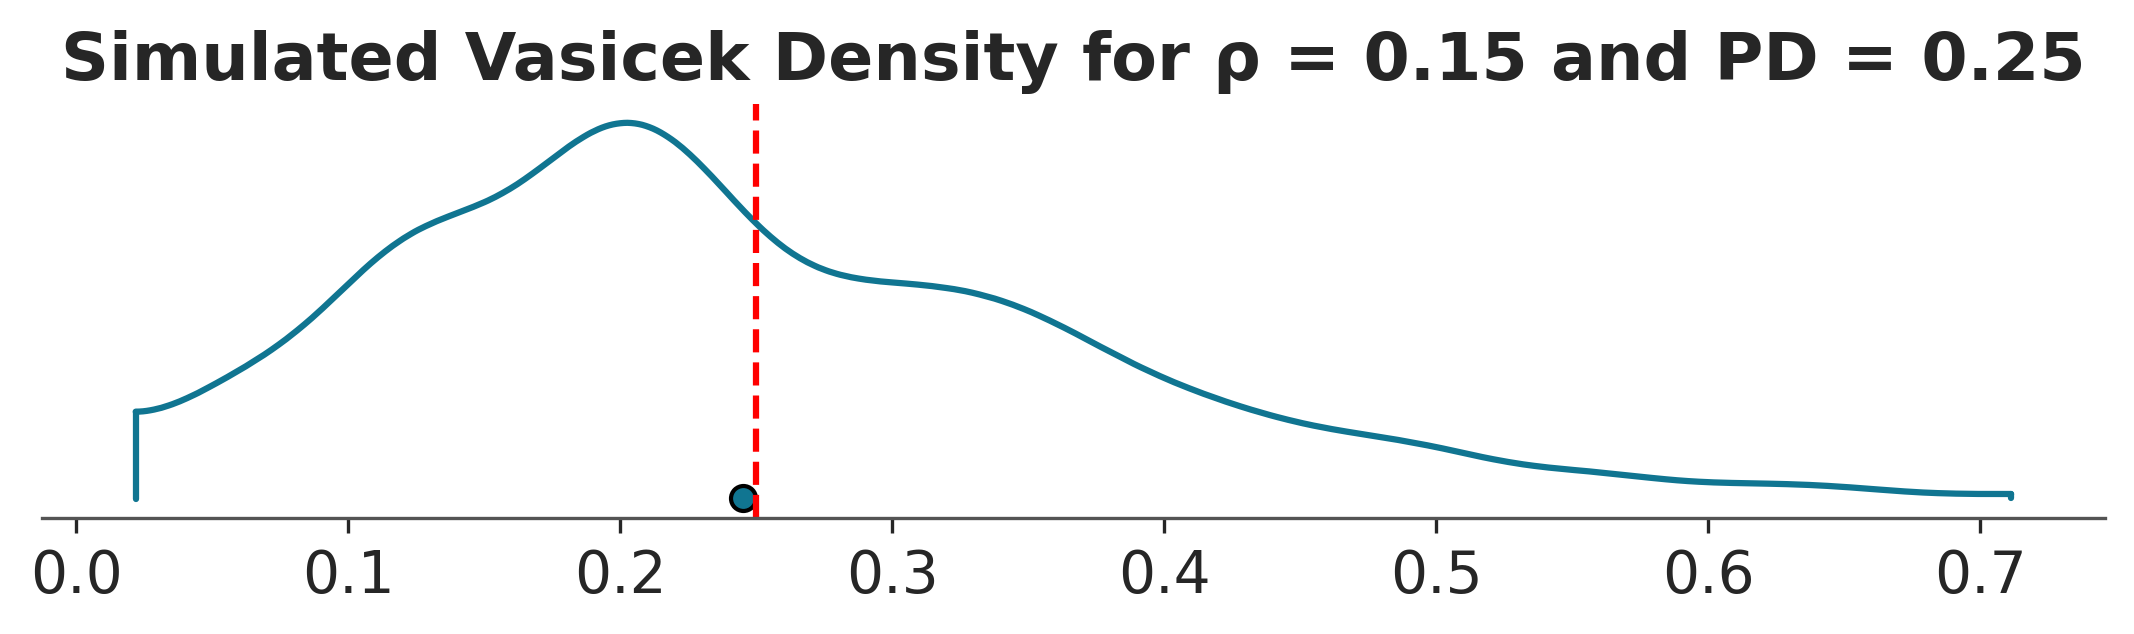

In [6]:
_, ax = plt.subplots(figsize=(7, 2))
az.plot_density({"": vasicek_sim}, hdi_prob=1, ax=ax)
ax.set_title("Simulated Vasicek Density for ρ = {} and PD = {}".format(ρsim, PDsim))
ax.axvline(PDsim, ls="--", color="red")
plt.show()

In [7]:
# Numpyro logprob for Vasicek
def vasicek_logprob(yobs:jnp.array, ρ:float, PD:float) -> jnp.array:
    '''
    logprob for Vasicek density
    '''

    num = norm.pdf( (jnp.sqrt(1-ρ)*norm.ppf(yobs, loc=0., scale=1.) - norm.ppf(PD, loc=0., scale=1.))/jnp.sqrt(ρ), loc=0., scale=1.)
    den = norm.pdf(norm.ppf(yobs, loc=0., scale=1.), loc=0., scale=1.)

    logpdf = jnp.log(jnp.sqrt(1-ρ)) + jnp.log(num) - jnp.log(jnp.sqrt(ρ)) - jnp.log(den)

    return logpdf

In [8]:
# Testing the logprob function
vasicek_logprob(0.25, 0.15, 0.25)

Array(1.085532, dtype=float32)

Numpyro Vasicek Model

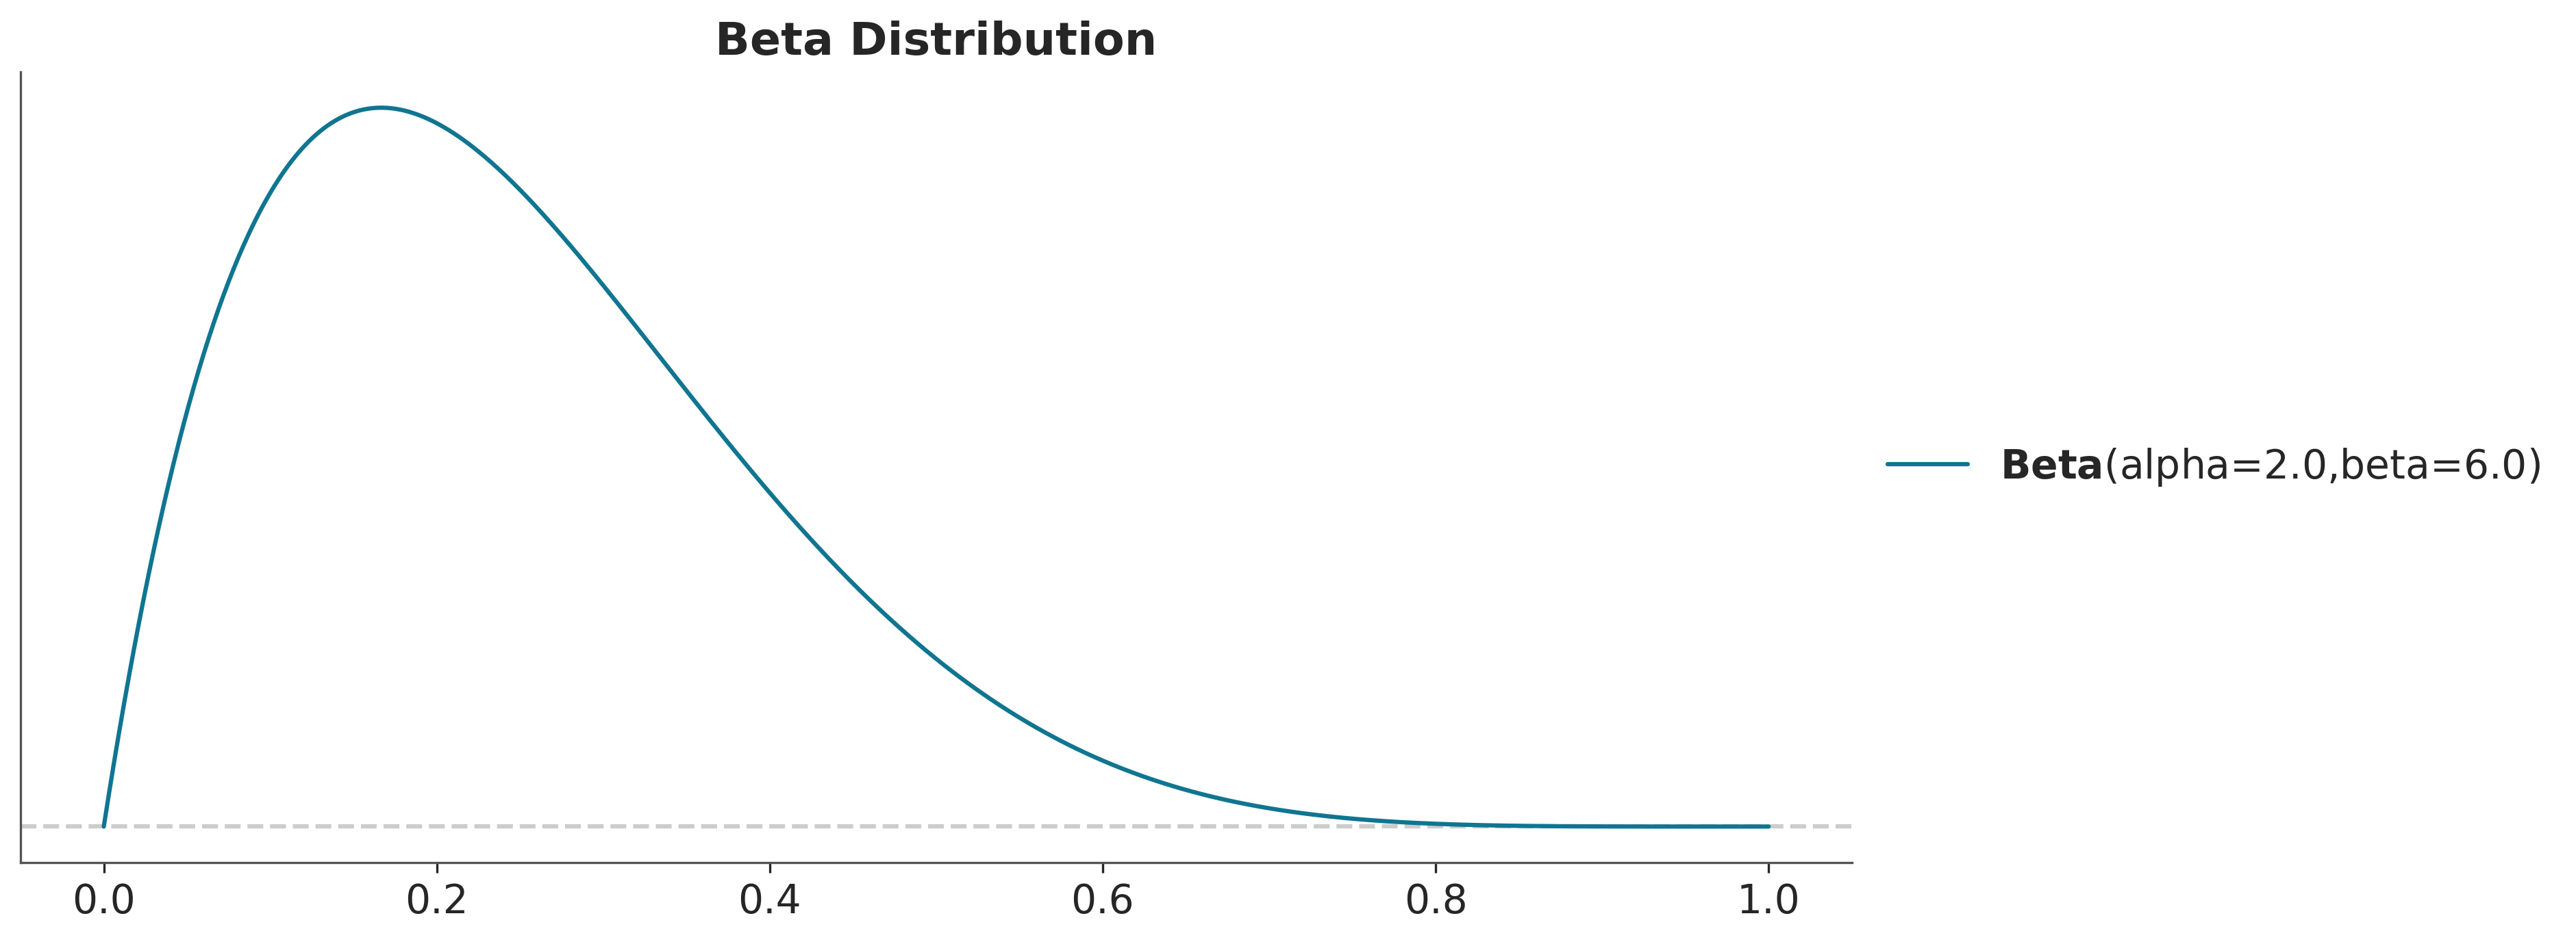

In [9]:
fig, ax = plt.subplots()
pz.Beta(2, 6).plot_pdf(ax=ax)
ax.set_title("Beta Distribution")
plt.show()

In [10]:
def vasicek_model(yobs:jnp.array) -> None:
    '''
    Numpyro Model to fit Vasicek Distribution
    '''

    # Prior
    ρ = numpyro.sample("ρ", dist.Uniform(low=-1., high=1.)) # Correlation: Bounded between -1 and 1
    PD = numpyro.sample("PD", dist.Beta(2., 6.)) # Probability of Default

    # Likelihood using logprob
    logprob = numpyro.factor("logprob", vasicek_logprob(yobs=yobs, ρ=ρ, PD=PD))

In [11]:
numpyro.render_model(vasicek_model, model_kwargs={"yobs":vasicek_sim})

There is no layout engine support for "dot"
Perhaps "dot -c" needs to be run (with installer's privileges) to register the plugins?


CalledProcessError: Command '[PosixPath('dot'), '-Kdot', '-Tsvg']' returned non-zero exit status 1. [stderr: 'There is no layout engine support for "dot"\nPerhaps "dot -c" needs to be run (with installer\'s privileges) to register the plugins?\n']

In [12]:
# Run inference on model
rng_key, rng_subkey = split(rng_key)
vasicek_mcmc = MCMC(NUTS(vasicek_model), num_warmup=1_000, num_samples=2_000, num_chains=4)
vasicek_mcmc.run(rng_subkey, 
                **{"yobs": vasicek_sim})

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [13]:
idata_vasicek = az.from_numpyro(vasicek_mcmc)

In [14]:
print(f"Number of divergences is {idata_vasicek['sample_stats']['diverging'].sum().item()}")

Number of divergences is 0


In [15]:
az.summary(idata_vasicek, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
PD,0.25,0.00,0.24,0.25,0.0,0.0,5314.06,5010.16,1.0
ρ,0.15,0.01,0.14,0.16,0.0,0.0,6024.30,5226.90,1.0


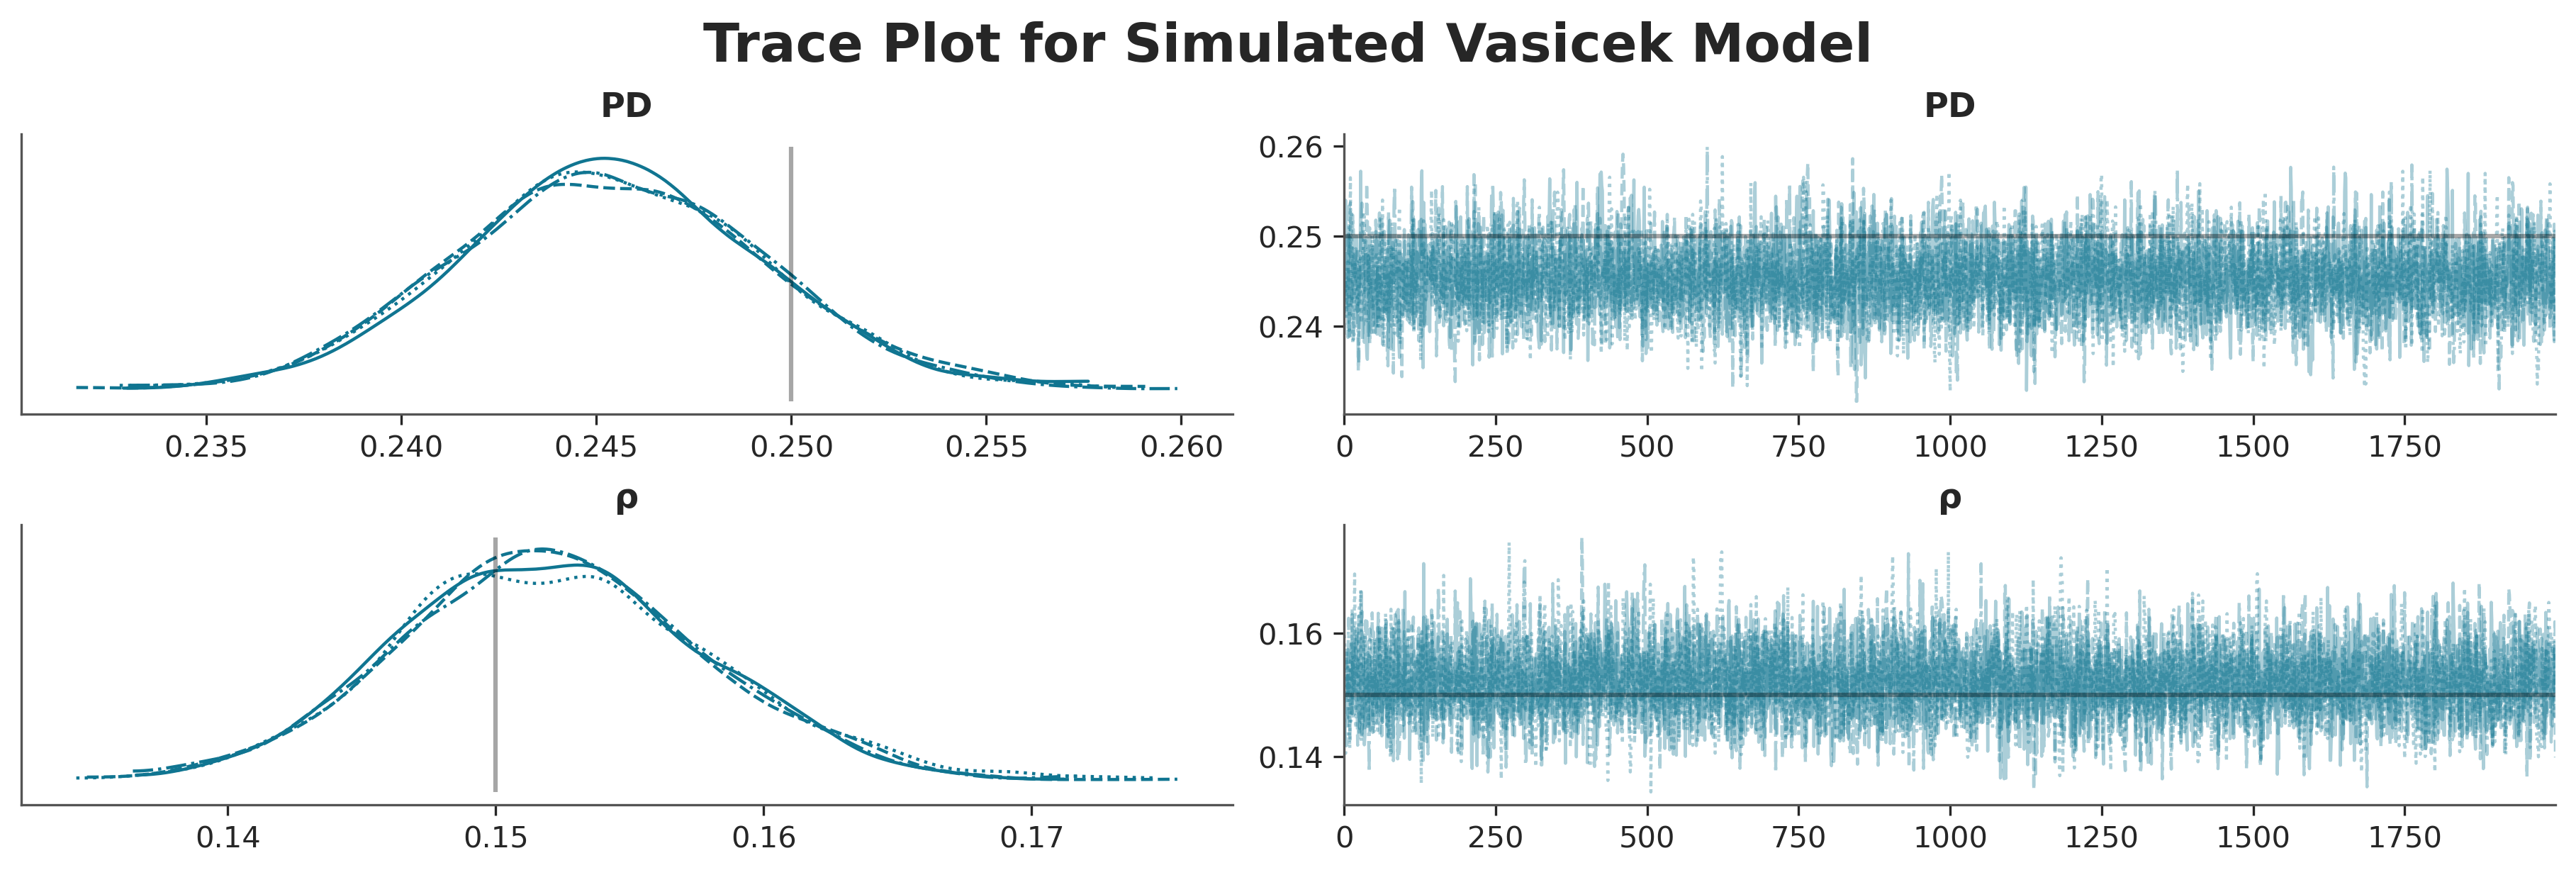

In [16]:
az.plot_trace(idata_vasicek,
             lines=[
                 ("ρ", {}, ρsim),
                 ("PD", {}, PDsim)
                   ]
             )
plt.suptitle("Trace Plot for Simulated Vasicek Model")
plt.show()